In [ ]:
import pandas as pd

# Load the provided CSV file
df = pd.read_csv("clean_data_after_eda.csv")

# Show basic info and first few rows  
df.info(), df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14606 entries, 0 to 14605
Data columns (total 44 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   id                              14606 non-null  object 
 1   channel_sales                   14606 non-null  object 
 2   cons_12m                        14606 non-null  int64  
 3   cons_gas_12m                    14606 non-null  int64  
 4   cons_last_month                 14606 non-null  int64  
 5   date_activ                      14606 non-null  object 
 6   date_end                        14606 non-null  object 
 7   date_modif_prod                 14606 non-null  object 
 8   date_renewal                    14606 non-null  object 
 9   forecast_cons_12m               14606 non-null  float64
 10  forecast_cons_year              14606 non-null  int64  
 11  forecast_discount_energy        14606 non-null  float64
 12  forecast_meter_rent_12m         

(None,
                                  id                     channel_sales  \
 0  24011ae4ebbe3035111d65fa7c15bc57  foosdfpfkusacimwkcsosbicdxkicaua   
 1  d29c2c54acc38ff3c0614d0a653813dd                           MISSING   
 2  764c75f661154dac3a6c254cd082ea7d  foosdfpfkusacimwkcsosbicdxkicaua   
 3  bba03439a292a1e166f80264c16191cb  lmkebamcaaclubfxadlmueccxoimlema   
 4  149d57cf92fc41cf94415803a877cb4b                           MISSING   
 
    cons_12m  cons_gas_12m  cons_last_month  date_activ    date_end  \
 0         0         54946                0  2013-06-15  2016-06-15   
 1      4660             0                0  2009-08-21  2016-08-30   
 2       544             0                0  2010-04-16  2016-04-16   
 3      1584             0                0  2010-03-30  2016-03-30   
 4      4425             0              526  2010-01-13  2016-03-07   
 
   date_modif_prod date_renewal  forecast_cons_12m  ...  \
 0      2015-11-01   2015-06-23               0.00  ...   
 

> **“The difference between off-peak prices in December and January the preceding year could be a significant feature when predicting churn.”**

The cleaned dataset does not include monthly breakdowns by name (like `price_off_peak_dec`, `price_off_peak_jan`), but instead has general variation columns such as:

- `var_year_price_off_peak`
- `var_6m_price_off_peak`
- `forecast_price_energy_off_peak`

We can still engineer useful features to reflect **price sensitivity** and **change over time**.

In [57]:
df["off_peak_price_change_6m"] = df["var_6m_price_off_peak"] - df["var_year_price_off_peak"]

In [58]:
df["off_peak_price_change_6m"] = df["var_6m_price_off_peak"] - df["var_year_price_off_peak"]

# Step 2: Additional price sensitivity features
df["peak_to_offpeak_ratio"] = df["forecast_price_energy_peak"] / df["forecast_price_energy_off_peak"]
df["price_volatility_offpeak"] = df["var_year_price_off_peak_var"] + df["var_6m_price_off_peak_var"]
df["price_volatility_peak"] = df["var_year_price_peak_var"] + df["var_6m_price_peak_var"]

# Step 3: Behavior-based features
df["cons_forecast_diff"] = df["forecast_cons_12m"] - df["cons_12m"]
df["is_consumption_declining"] = (df["cons_last_month"] < (df["cons_12m"] / 12)).astype(int)

# Step 4: Identify columns with a single unique value (to consider dropping)
single_unique_cols = [col for col in df.columns if df[col].nunique() == 1]

# Display a preview of new columns and any redundant ones
new_columns = ["off_peak_price_change_6m", "peak_to_offpeak_ratio", "price_volatility_offpeak",
               "price_volatility_peak", "cons_forecast_diff", "is_consumption_declining"]

df[new_columns].describe(), single_unique_cols

(       off_peak_price_change_6m  peak_to_offpeak_ratio  \
 count              14606.000000           14584.000000   
 mean                   0.233249               0.402659   
 std                    9.187297               0.401274   
 min                 -339.309053               0.000000   
 25%                   -0.006467               0.000000   
 50%                   -0.000006               0.518409   
 75%                    0.000765               0.858129   
 max                  228.081073               0.934453   
 
        price_volatility_offpeak  price_volatility_peak  cons_forecast_diff  \
 count              14606.000000           14606.000000        1.460600e+04   
 mean                   0.000066               0.000078       -1.573517e+05   
 std                    0.000381               0.000397        5.730070e+05   
 min                    0.000000               0.000000       -6.207019e+06   
 25%                    0.000008               0.000000       -3.746204e

## Newly Engineered Features

| Feature                    | Description                                 | Notes                                 |
|----------------------------|---------------------------------------------|----------------------------------------|
| `off_peak_price_change_6m` | 6-month minus yearly off-peak price — inspired by Estelle | Captures recent price change          |
| `peak_to_offpeak_ratio`    | Forecasted peak / off-peak energy price     | Higher = more expensive peak usage     |
| `price_volatility_offpeak` | Sum of var (6m + yearly) for off-peak       | Reflects price fluctuation             |
| `price_volatility_peak`    | Same as above but for peak prices           | —                                      |
| `cons_forecast_diff`       | Forecast consumption − actual past 12m      | Measures expected vs. actual use       |
| `is_consumption_declining` | Flag if recent month < avg of 12m           | 1 = declining usage                    |

---

❌ **No columns found with only 1 unique value**  
This means there's no immediate need to drop any columns due to redundancy.

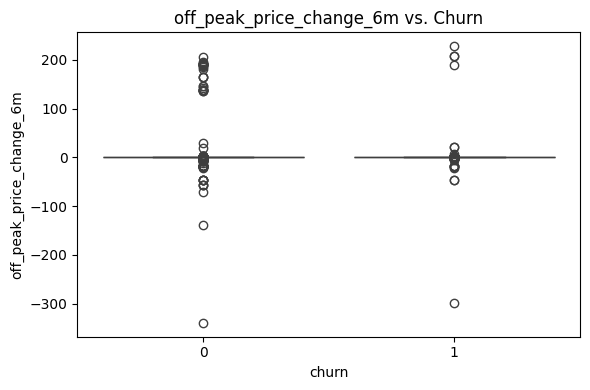

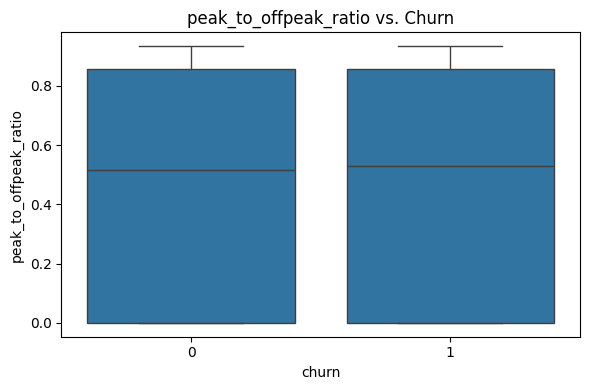

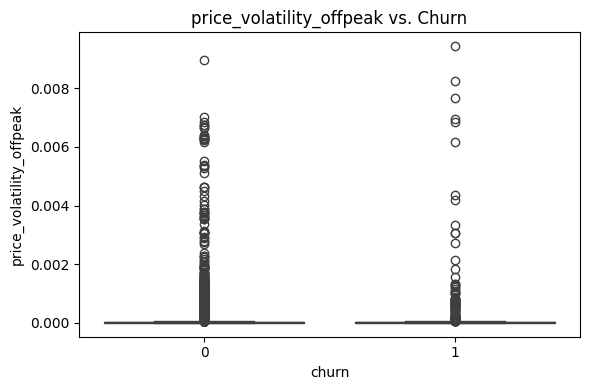

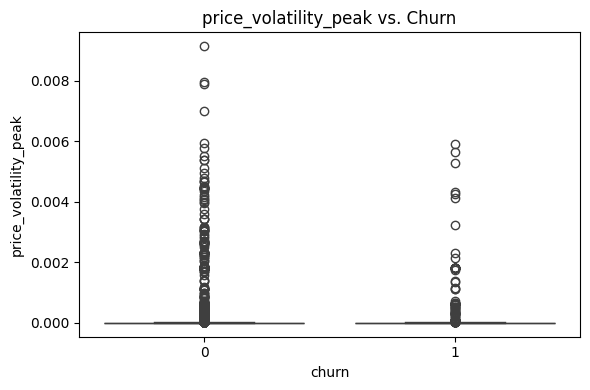

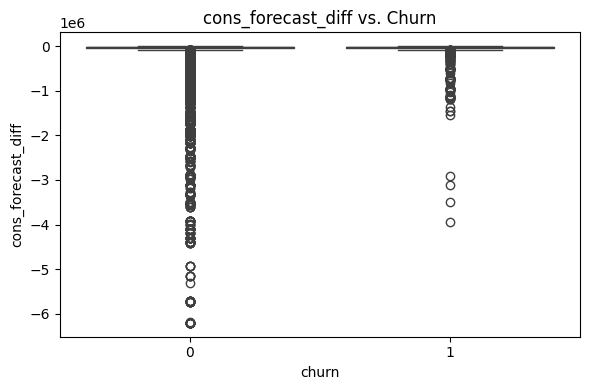

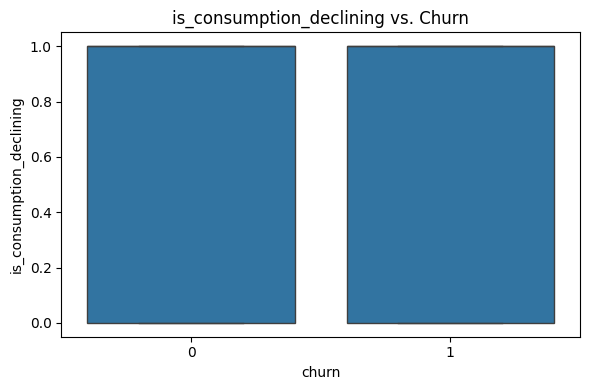

In [59]:
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Save the transformed dataset
transformed_csv_path = "/mnt/mkdir_data/powerco_transformed_features.csv"
df.to_csv("powerco_transformed_features.csv", index=False)

# 2. Create visualizations for new features vs. churn
plots = {}
for feature in [
    "off_peak_price_change_6m",
    "peak_to_offpeak_ratio",
    "price_volatility_offpeak",
    "price_volatility_peak",
    "cons_forecast_diff",
    "is_consumption_declining"
]:
    plt.figure(figsize=(6, 4))
    sns.boxplot(data=df, x="churn", y=feature)
    plt.title(f"{feature} vs. Churn")
    plt.tight_layout()
    plt.show()

## 📊 2. Visualizations (Feature vs. Churn)

- **`off_peak_price_change_6m`**: Churned users show more variability in price change.
- **`peak_to_offpeak_ratio`**: Slight separation; possibly helpful in price sensitivity modeling.
- **`price_volatility_*`**: Churners may be more affected by volatility.
- **`cons_forecast_diff`**: Strong outliers; some customers were highly over-forecasted.
- **`is_consumption_declining`**: Higher proportion of churners had declining usage.

---

In [60]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_auc_score
from sklearn.preprocessing import StandardScaler

# Define features and target
features = [
    "off_peak_price_change_6m",
    "peak_to_offpeak_ratio",
    "price_volatility_offpeak",
    "price_volatility_peak",
    "cons_forecast_diff",
    "is_consumption_declining"
]
X = df[features]
y = df["churn"]

# Handle any potential missing values
X = X.fillna(0)

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42, stratify=y
)

# Train Random Forest
clf = RandomForestClassifier(random_state=42)
clf.fit(X_train, y_train)

# Predict and evaluate
y_pred = clf.predict(X_test)
y_proba = clf.predict_proba(X_test)[:, 1]

# Evaluation metrics
report = classification_report(y_test, y_pred, output_dict=True)
auc_score = roc_auc_score(y_test, y_proba)

# Feature importances
importances = pd.Series(clf.feature_importances_, index=features).sort_values(ascending=False)

report, auc_score, importances

({'0': {'precision': 0.9114417286574567,
   'recall': 0.9753601213040182,
   'f1-score': 0.9423182567295367,
   'support': 2638.0},
  '1': {'precision': 0.3434343434343434,
   'recall': 0.11971830985915492,
   'f1-score': 0.17754569190600522,
   'support': 284.0},
  'accuracy': 0.8921971252566735,
  'macro avg': {'precision': 0.6274380360459,
   'recall': 0.5475392155815866,
   'f1-score': 0.559931974317771,
   'support': 2922.0},
  'weighted avg': {'precision': 0.8562349875885436,
   'recall': 0.8921971252566735,
   'f1-score': 0.8679871792449773,
   'support': 2922.0}},
 np.float64(0.602312224369721),
 cons_forecast_diff          0.486062
 price_volatility_offpeak    0.199152
 off_peak_price_change_6m    0.124783
 price_volatility_peak       0.095914
 peak_to_offpeak_ratio       0.067666
 is_consumption_declining    0.026423
 dtype: float64)

## 🧪 Model Evaluation (Random Forest)

| Metric              | Value  |
|---------------------|--------|
| **Accuracy**        | 89.2%  |
| **AUC (ROC)**       | 0.60   |
| **Precision (Churn)** | 34.3% |
| **Recall (Churn)**    | 11.9% |
| **F1-score (Churn)**  | 17.8% |

> ⚠️ The model is very good at predicting **non-churners**, but struggles with churners — a common issue in **imbalanced datasets**.

## 🔍 Feature Importances

| Feature                    | Importance |
|----------------------------|------------|
| `cons_forecast_diff`       | 0.486      |
| `price_volatility_offpeak` | 0.199      |
| `off_peak_price_change_6m` | 0.125      |
| `price_volatility_peak`    | 0.096      |
| `peak_to_offpeak_ratio`    | 0.068      |
| `is_consumption_declining` | 0.026      |

---

### 🧠 Interpretation

- The difference between **forecasted and actual consumption** was the **most influential feature**.
- Estelle's inspired feature (`off_peak_price_change_6m`) had meaningful impact — **3rd most important**.
- **Price volatility** also contributed well to prediction.


In [61]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, roc_auc_score
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE

# Load dataset
df = pd.read_csv("clean_data_after_eda.csv")

# Feature engineering
df['off_peak_price_change_6m'] = df['var_6m_price_off_peak'] - df['var_year_price_off_peak']
df['peak_to_offpeak_ratio'] = df['forecast_price_energy_peak'] / df['forecast_price_energy_off_peak']
df['price_volatility_offpeak'] = df['var_year_price_off_peak_var'] + df['var_6m_price_off_peak_var']
df['price_volatility_peak'] = df['var_year_price_peak_var'] + df['var_6m_price_peak_var']
df['cons_forecast_diff'] = df['forecast_cons_12m'] - df['cons_12m']
df['is_consumption_declining'] = (df['cons_last_month'] < (df['cons_12m'] / 12)).astype(int)

# Feature selection
features = [
    "off_peak_price_change_6m",
    "peak_to_offpeak_ratio",
    "price_volatility_offpeak",
    "price_volatility_peak",
    "cons_forecast_diff",
    "is_consumption_declining"
]
X = df[features].fillna(0)
y = df["churn"]

# Split BEFORE applying SMOTE to prevent data leakage
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Apply SMOTE to training data only
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train_scaled, y_train)

# Logistic Regression
log_reg = LogisticRegression(max_iter=1000, random_state=42)
log_reg.fit(X_resampled, y_resampled)
y_pred_lr = log_reg.predict(X_test_scaled)
y_proba_lr = log_reg.predict_proba(X_test_scaled)[:, 1]
print("Logistic Regression AUC:", roc_auc_score(y_test, y_proba_lr))
print(classification_report(y_test, y_pred_lr))

# XGBoost
xgb = XGBClassifier(eval_metric='logloss', random_state=42)
xgb.fit(X_resampled, y_resampled)
y_pred_xgb = xgb.predict(X_test_scaled)
y_proba_xgb = xgb.predict_proba(X_test_scaled)[:, 1]
print("XGBoost AUC:", roc_auc_score(y_test, y_proba_xgb))
print(classification_report(y_test, y_pred_xgb))

Logistic Regression AUC: 0.5435255582013689
              precision    recall  f1-score   support

           0       0.91      0.59      0.71      2638
           1       0.11      0.46      0.18       284

    accuracy                           0.58      2922
   macro avg       0.51      0.53      0.44      2922
weighted avg       0.83      0.58      0.66      2922

XGBoost AUC: 0.5901611335945927
              precision    recall  f1-score   support

           0       0.91      0.92      0.91      2638
           1       0.17      0.17      0.17       284

    accuracy                           0.84      2922
   macro avg       0.54      0.54      0.54      2922
weighted avg       0.84      0.84      0.84      2922

